# Hands-on (CNN: Chest X-ray Classification)

# 0. Preliminary

First of all, please change the hardware accelerator to `GPU` in the notebook settings.

In [ ]:
!nvidia-smi

Tue Jul 30 17:12:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Let's import required libraries and datasets.

We will use chest X-ray images to train a simple CNN and two standard CNN-based networks, VGGNet and ResNet.

In [ ]:
# to load data and process
import os
import time
import zipfile

import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageOps

!pip install datasets
from datasets import load_dataset

# modeling and training stuffs
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torch.__version__}")

torch version: 2.3.1+cu121
torchvision version: 2.3.1+cu121


### 0.1. Load Data

The [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,866 X-Ray images (JPEG) in total.

We provide a zipped file:


**Option 1**: If you have already downloaded the ZIP file and uploaded it to Google Drive, you can mount your Google Drive.

**Option 2**: If the ZIP file is not downloaded in advance, download it online and proceed accordingly.

**Option 1**: mount

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')
# os.listdir("/content/drive/MyDrive/xray_classification")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


['chest_xray.zip']

In [ ]:
# data_path = "/content/drive/MyDrive/xray_classification"

# file_name = "chest_xray.zip"
# with zipfile.ZipFile(os.path.join(data_path, file_name), 'r') as zf:
#     zf.extractall()

# print(f'{file_name} 압축 해제 완료')

chest_xray.zip 압축 해제 완료


**Option 2**: download zipfile online. Uncomment one of the seven options.

In [ ]:
# !pip install gdown

# # !gdown --id 11kYj-KA46VB_A9lERsH3FrvRjLWMd1Nw --output chest_xray.zip
# # !gdown --id 1V1OoNRAejmMymd3bzTADfEMzymvtSVpE --output chest_xray.zip
# # !gdown --id 1WNFD-jg0h5nfQn4IF1x2zcA6YR2OSLM7 --output chest_xray.zip
# # !gdown --id 1-JZkC8-UGiJ3cMHTNJZ6e1mc73vCcaMT --output chest_xray.zip
# # !gdown --id 1gYzfTDUgmk-6o8MTeuSOT_ie_eZgjId_ --output chest_xray.zip
# # !gdown --id 1tnKJKShgBQMgwTcgfTN9cm9xw24lmUMO --output chest_xray.zip
# # !gdown --id 1E_z9FDTzyu6wHNFiCgZRB41PjC9rSKFI --output chest_xray.zip

# file_name = "chest_xray.zip"
# with zipfile.ZipFile(file_name, 'r') as zf:
#     zf.extractall()

# print(f'{file_name} 압축 해제 완료')

**Option 3**: download dataset from hugginface dataset if available

In [ ]:
ds = load_dataset("hf-vision/chest-xray-pneumonia")

def save_images_to_local(dataset, split_name, base_dir="chest_xray"):
    split_dir = "val" if split_name == "validation" else split
    for i, example in enumerate(tqdm(dataset)):
        label = "PNEUMONIA" if example['label'] == 1 else "NORMAL"
        save_dir = os.path.join(base_dir, split_dir, label)
        os.makedirs(save_dir, exist_ok=True)  # 디렉토리 생성

        img = example['image']
        img_save_path = os.path.join(save_dir, f"{i}.jpeg")
        img.save(img_save_path)

for split in ["train", "validation", "test"]:
    save_images_to_local(ds[split], split_name=split)


Basic Data information.

In [ ]:
for split in ["train", "val", "test"]:
    print(f"{split} set:")
    print("-"*60)
    print(f"""PNEUMONIA={len(os.listdir(os.path.join("chest_xray", split, "PNEUMONIA")))}""")
    print(f"""NORMAL={len(os.listdir(os.path.join("chest_xray", split, "NORMAL")))}""")
    print()

train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

val set:
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8

test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234



Since the size of validation set is too small (< 10) to be evaluated properly, 20% of the train set will be used as an additional valid set.

In [ ]:
def move_from_to_n(src_dir, dst_dir, ratio):
    if len(os.listdir(dst_dir)) > 10:
        raise NotImplementedError("valid set already has sufficient data size. :D")

    # move files, no duplicates!
    fs = sorted(os.listdir(src_dir))
    n = int(len(fs) * ratio)
    assert len(fs) >= n
    i=0
    targ = fs[-n:]
    # print('targ', targ)
    for f in targ:
        # print('move_from_to_n', i, f, src_dir, dst_dir)
        os.rename(src_dir+'/'+f, dst_dir+'/'+f)
        i+=1
    print('copied', i, src_dir, dst_dir)

In [ ]:
move_from_to_n(src_dir="chest_xray/train/NORMAL", dst_dir="chest_xray/val/NORMAL", ratio=0.2)
move_from_to_n(src_dir="chest_xray/train/PNEUMONIA", dst_dir="chest_xray/val/PNEUMONIA", ratio=0.2)

copied 268 chest_xray/train/NORMAL chest_xray/val/NORMAL
copied 775 chest_xray/train/PNEUMONIA chest_xray/val/PNEUMONIA


Basic Data information. (after moving files)

In [ ]:
for split in ["train", "val", "test"]:
    print(f"{split} set:")
    print("-"*60)
    print(f"""PNEUMONIA={len(os.listdir(os.path.join("chest_xray", split, "PNEUMONIA")))}""")
    print(f"""NORMAL={len(os.listdir(os.path.join("chest_xray", split, "NORMAL")))}""")
    print()

train set:
------------------------------------------------------------
PNEUMONIA=3100
NORMAL=1073

val set:
------------------------------------------------------------
PNEUMONIA=783
NORMAL=276

test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234



## 0.2. Simple Data EDA

### X-ray images having `PNEUMONIA`

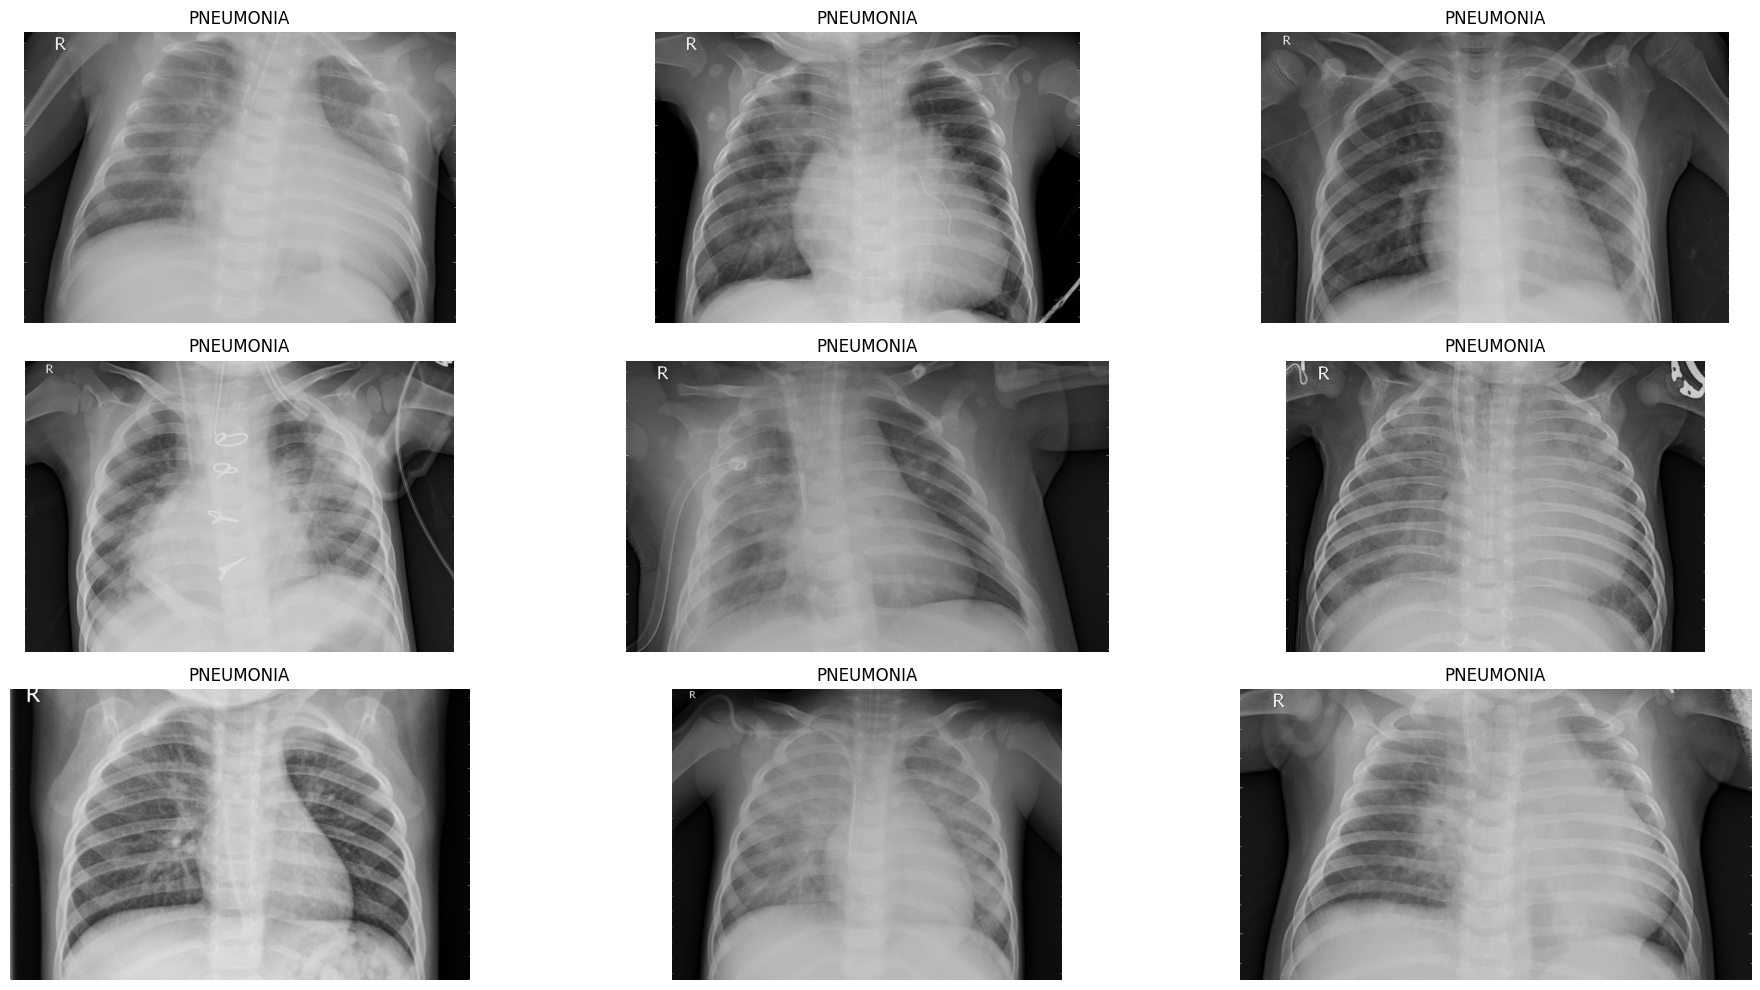

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    _files = os.listdir("chest_xray/train/PNEUMONIA")
    img = plt.imread(os.path.join("chest_xray/train/PNEUMONIA", _files[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

### X-ray images having `NORMAL`

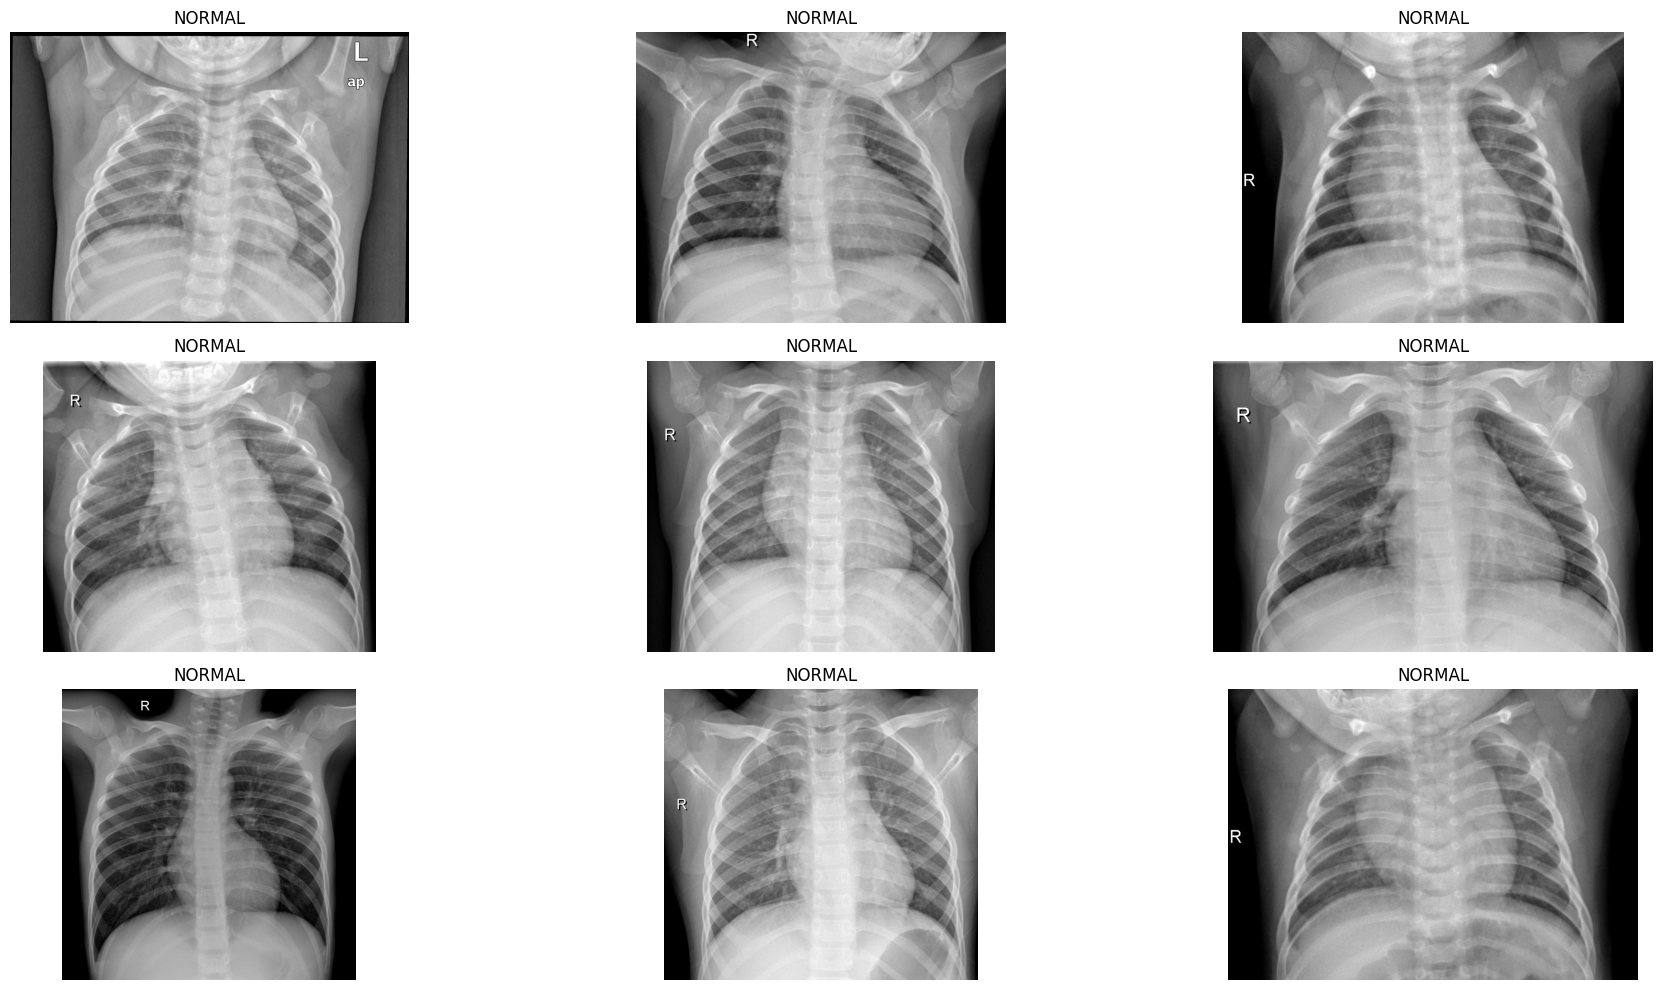

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    _files = os.listdir("chest_xray/train/NORMAL")
    img = plt.imread(os.path.join("chest_xray/train/NORMAL", _files[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

### Training Dataset size

In [ ]:
train_labels = [1]*len(os.listdir("chest_xray/train/PNEUMONIA/")) + [0]*len(os.listdir("chest_xray/train/NORMAL/"))
val_labels = [1]*len(os.listdir("chest_xray/val/PNEUMONIA/")) + [0]*len(os.listdir("chest_xray/val/NORMAL/"))
# test_labels = [1]*len(os.listdir("./test/PNEUMONIA/")) + [0]*len(os.listdir(os.listdir("./test/NORMAL/"))
print(f"""Number of samples (in training data)\t: {len(train_labels)}""")
print(f"""Number of samples (in validation data)\t: {len(val_labels)}""")

Number of samples (in training data)	: 4173
Number of samples (in validation data)	: 1059


### Prevalence of labels

In [ ]:
print(f"""Number of Positive samples (in training data)\t: {sum(train_labels)}/{len(train_labels)} (ratio : {sum(train_labels)/(len(train_labels)):.2f})""")
print(f"""Number of Positive samples (in validation data)\t: {sum(val_labels):4d}/{len(val_labels)} (ratio : {sum(val_labels)/(len(val_labels)):.2f})""")

Number of Positive samples (in training data)	: 3100/4173 (ratio : 0.74)
Number of Positive samples (in validation data)	:  783/1059 (ratio : 0.74)


### Prevalance of labels

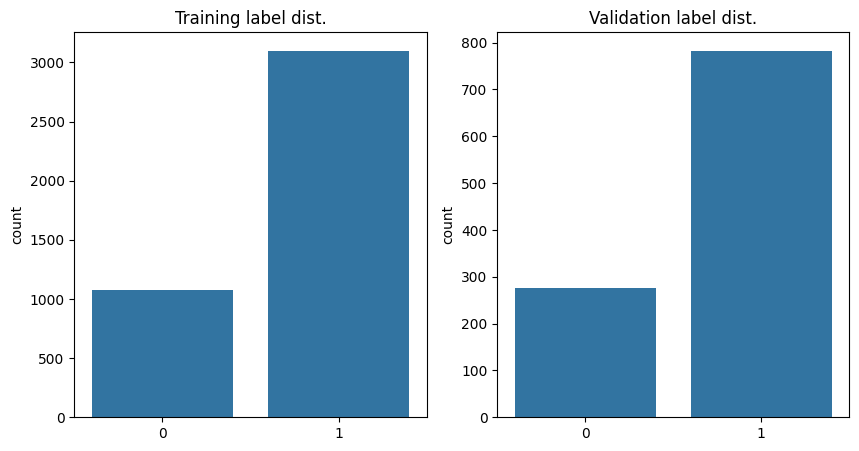

In [ ]:
# number of images for each class
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.countplot(x=train_labels, ax=ax0)
ax0.set_title('Training label dist.')

sns.countplot(x=val_labels, ax=ax1)
ax1.set_title('Validation label dist.')

plt.show()

## 0.3. Build Dataset/Dataloader Class

### Transforming and augmenting images
- Transforms are common image transformations available in the `torchvision.transforms` module.
- They can be chained together using `Compose`.
- Most transformations accept both PIL images and tensor images, although some transformations are PIL-only and some are tensor-only.
- The Conversion Transforms (e.g., `ToTensor`) may be used to convert to and from PIL images.

More information can be found at https://pytorch.org/vision/stable/transforms.html#transforming-and-augmenting-images

In [ ]:
sample_path = "chest_xray/train/PNEUMONIA"
sample_data = os.path.join(sample_path,os.listdir(sample_path)[1])
sample_image = Image.open(sample_data)  # open jpeg file

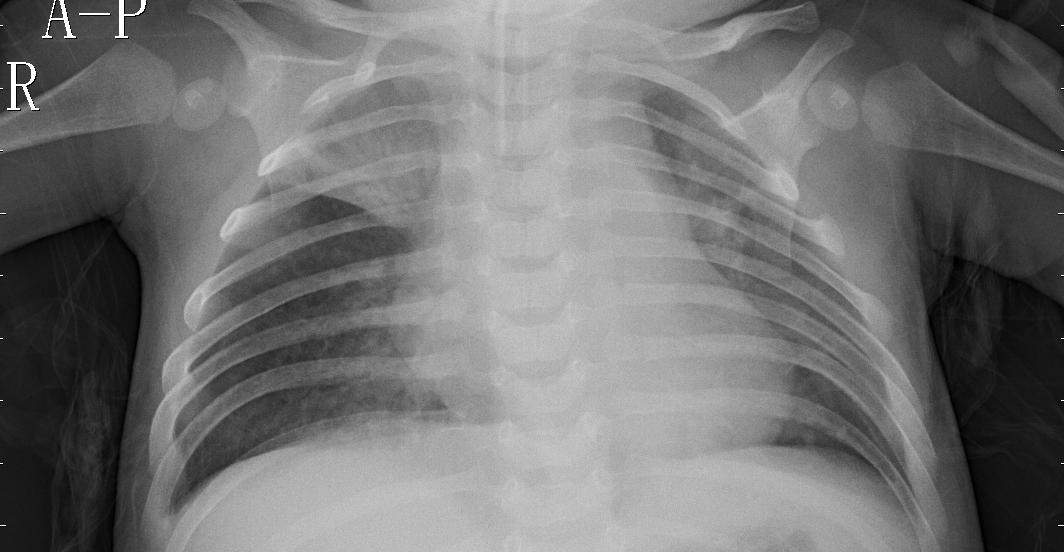

In [ ]:
sample_image

In [ ]:
print(f"size: {sample_image.size}")
print(f"mode: {sample_image.mode}")
print(f"np.array shape: {np.array(sample_image).shape}")

size: (1064, 552)
mode: L
np.array shape: (552, 1064)


In [ ]:
sample_image = sample_image.convert("RGB")
print("After RGB conversion,")
print(f"size: {sample_image.size}")
print(f"mode: {sample_image.mode}")
print(f"np.array shape: {np.array(sample_image).shape}")

After RGB conversion,
size: (1064, 552)
mode: RGB
np.array shape: (552, 1064, 3)


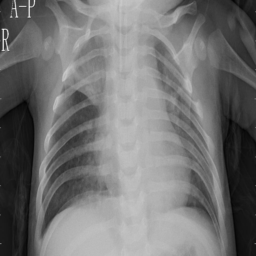

In [ ]:
transform_fn = transforms.Resize(size=(256,256))
transform_fn(sample_image)

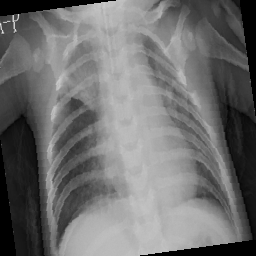

In [ ]:
transform_fn = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomRotation(degrees=(-20, 20)),
])
transform_fn(sample_image)

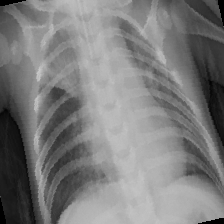

In [ ]:
transform_fn = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.CenterCrop(size=(224,224)),
])
transform_fn(sample_image)

In [ ]:
transform_fn = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
])
transform_fn(sample_image)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
transform_fn = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
transform_fn(sample_image)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

### Construct Dataset/Dataloader

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
def data_transforms(split):

    if split == "train":
        data_T = transforms.Compose([
                transforms.Resize(size=(256,256)),
                transforms.RandomRotation(degrees=(-20,+20)),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
    elif split == "test" or split == "val":
        data_T = transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
    else:
        raise ValueError()

    return data_T

In [ ]:
def get_chestXray_loader_v1(batch_size=32):

    # train
    train_data = []
    for label, category in enumerate(['NORMAL', 'PNEUMONIA']):
        ct_dir = os.path.join('chest_xray', 'train', category)
        for img in tqdm(os.listdir(ct_dir)):
            x = data_transforms("train")(
                    Image.open(os.path.join(ct_dir, img)).convert("RGB"),
            )
            train_data.append([x, label])
    print('Train data processing done')

    # validation
    val_data = []
    for label, category in enumerate(['NORMAL', 'PNEUMONIA']):
        ct_dir = os.path.join('chest_xray', 'val', category)
        for img in tqdm(os.listdir(ct_dir)):
            x = data_transforms("val")(
                    Image.open(os.path.join(ct_dir, img)).convert("RGB"),
            )
            val_data.append([x, label])
    print('Validation data processing done')

    # test
    test_data = []
    for label, category in enumerate(['NORMAL', 'PNEUMONIA']):
        ct_dir = os.path.join('chest_xray', 'test', category)
        for img in tqdm(os.listdir(ct_dir)):
            x = data_transforms("test")(
                Image.open(os.path.join(ct_dir, img)).convert("RGB"),
            )
            test_data.append([x, label])
    print('Test data processing done')

    data_loader = {}
    data_loader['train'] = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    data_loader['val'] = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    data_loader['test'] = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return data_loader

In [ ]:
data_loader = get_chestXray_loader_v1(batch_size=32)

  0%|          | 0/1073 [00:00<?, ?it/s]

  0%|          | 0/3100 [00:00<?, ?it/s]

Train data processing done


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

Validation data processing done


  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Test data processing done


Or we can use `torchvision.datasets.ImageFolder`.

A generic data loader where the images are arranged in this way by default:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png
```


In [ ]:
def get_chestXray_loader_v2(batch_size=32):

    from torchvision import datasets

    data_dir = "./chest_xray"
    train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=data_transforms("train"))
    val_data = datasets.ImageFolder(os.path.join(data_dir,"val"), transform=data_transforms("val"))
    test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=data_transforms("test"))

    data_loader = {}
    data_loader['train'] = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    data_loader['val'] = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    data_loader['test'] = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return data_loader

In [ ]:
data_loader = get_chestXray_loader_v2(batch_size=32)

### Sanity Checking data from Dataset/Dataloader

In [ ]:
sample_data = data_loader["train"].dataset[0]
print(sample_data[0].shape, sample_data[1])

for batch in data_loader["train"]:
    break
print(batch[0].shape, batch[1].shape)

torch.Size([3, 224, 224]) 0
torch.Size([32, 3, 224, 224]) torch.Size([32])


# 1. Convolutional, Batch Norm and Dropout Layer Practice

## 1.1. Convolutional Layer

In PyTorch, 2-dimensional convolutional layer is given with the pytorch `torch.nn.Conv2d` package. In this section, we will learn basic usage of pytorch convolutional layer with some example codes and practices.

As in our lecture session, we should specify convolution with the number of channels of input and output, kernel size, the size of stride and padding. In Pytorch `torch.nn.Conv2d` class, those traits can be specified as class parameters. The detailed explanation and default values are available on below and the official sites (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)


- **in_channels** (int) – Number of channels in the input image
- **out_channels** (int) – Number of channels produced by the convolution
- **kernel_size** (int or tuple) – Size of the convolving kernel
- **stride** (int or tuple, optional) – Stride of the convolution. Default: 1
- **padding** (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0

Now, let's define our convolutional layer and practice. As in our lecture note, let's suppose we have 32x32-sized image with 3 channels.

In [ ]:
"""
Note: Since PyTorch Conv2d receives 4-dimensional input (i.e. a batch of image(s)),
we define input x with the first argument 1.
"""
x = torch.randn(1, 3, 32, 32)

In [ ]:
x.shape

torch.Size([1, 3, 32, 32])

Then, the number of input channel is 3, which is the same value with the input images' channel (the second argument of above `randn` method).

How about the number of output channel, kernel and stride size? Following the figure in our lecture note, we can easily see that the number of output channel should be 1. You can naively regard the kernel size as the spatial size of filter in the lecture note. Thus, the kernel size should be (5,5), and the stride size should be 1. In practice, since the spatial size of filter in in square form (i.e., width = height), we usually specifiy kernel size with only single integer (in our case 5).

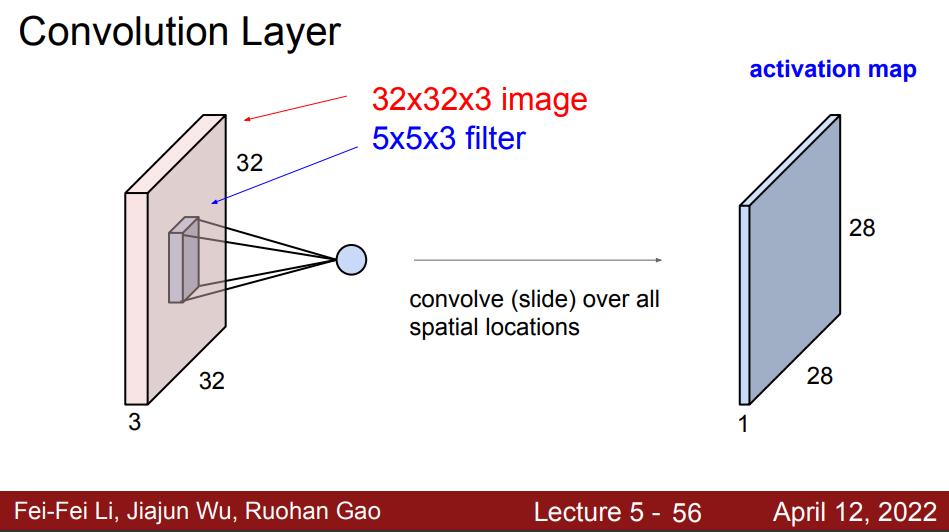

In [ ]:
x = torch.randn(1, 3, 32, 32)

In [ ]:
# Fill out the ?? of below
conv_layer = torch.nn.Conv2d(in_channels=?, out_channels=?, kernel_size=?, stride=1)

In [ ]:
# You should check the output size of convolution layer is [1, 1, 28, 28].
conv_layer(x).size()

torch.Size([1, 1, 28, 28])

Also check the other example in the lecture note as below.
* Input volume: 3x32x32
* 10 5x5 filters with stride 1, pad 2

In [ ]:
x = torch.randn(1, 3, 32, 32)
conv_layer = torch.nn.Conv2d(in_channels=?, out_channels=?, kernel_size=?, stride=?, padding=?)
print(conv_layer(x).size())

torch.Size([1, 10, 32, 32])


## 1.2. BatchNorm and Dropout layer

In a similar manner, batch normalization and dropout layer also can be used from `torch.nn.BatchNorm2d` and `torch.nn.Dropout2d`.

In [ ]:
x = torch.randn(1, 3, 32, 32)

bn = torch.nn.BatchNorm2d(num_features=3)
print(bn(x).size()) # check batch norm does not change the size of input

dropout = torch.nn.Dropout2d(p=0.5) # dropout can specify probability of an element to be zeroed.
print(dropout(bn(x)).size()) # check dropout does not change the size of input

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [ ]:
"""
Provide some evidences for the implementation of BatchNorm & DropOut
"""
def show_evidence_plot_for_batch_norm():
    import torch
    import torch.nn as nn
    import matplotlib.pyplot as plt

    x = torch.randn(128, 3, 32, 32)
    x = x * 100  # amplify
    bn = nn.BatchNorm2d(num_features=3)
    assert x.size() == bn(x).size()

    x_c1 = x[:,0,:,:].flatten()
    bn_x_c1 = bn(x)[:,0,:,:].detach().flatten()

    plt.hist(x_c1, bins=20)
    plt.title(f"mean={x_c1.mean():.4f}, std={x_c1.std():.2f}")
    plt.show()

    plt.hist(bn_x_c1, bins=20)
    plt.title(f"mean={bn_x_c1.mean():.4f}, std={bn_x_c1.std():.2f}")
    plt.show()


def show_evidence_plot_for_dropout():
    import matplotlib.pyplot as plt
    import torch
    import torch.nn as nn

    x = torch.ones((1, 3, 32, 32))
    # Here, we use simple nn.Dropout not nn.Dropout2d
    # dropout = nn.Dropout2d(p=0.5)
    dropout = nn.Dropout(p=0.5)

    _before = x[0,0,:,:]
    print(_before.sum())
    plt.imshow(_before, cmap='gray')
    plt.show()
    print(_before[:4, :4])

    _after = dropout(x)[0,0,:,:]
    print(_after.sum())
    plt.imshow(_after, cmap='gray')
    plt.show()
    print(_after[:4, :4])

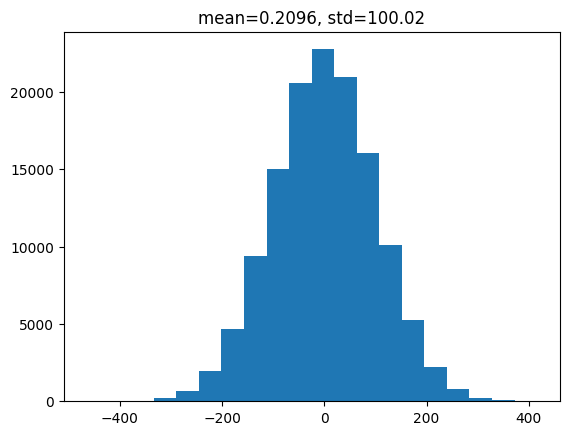

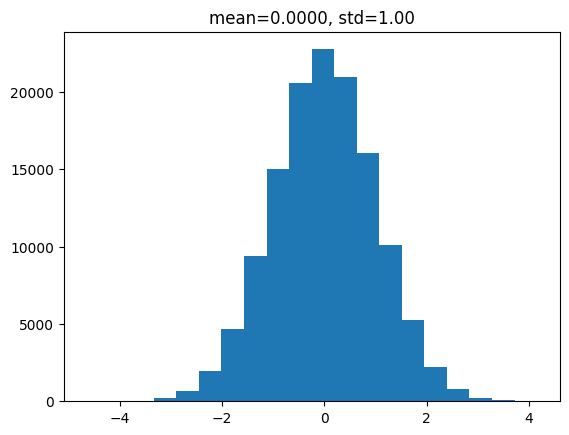

In [ ]:
show_evidence_plot_for_batch_norm()

tensor(1024.)


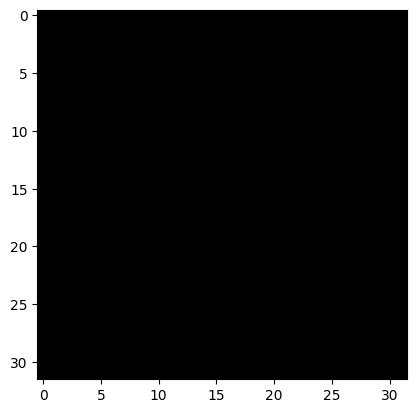

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor(1086.)


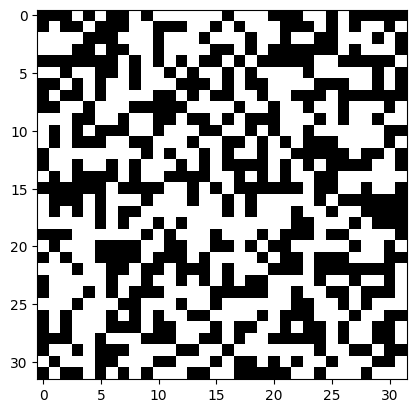

tensor([[0., 0., 0., 2.],
        [0., 2., 0., 0.],
        [2., 2., 2., 2.],
        [2., 2., 2., 0.]])


In [ ]:
show_evidence_plot_for_dropout()

## 1.3. Build a Simple Convolutional Neural Network

We can combine convolution layer, batch norm layer and activation function (e.g., ReLU) to construct a functional unit. In this case, we can use `torch.nn.Sequential` to define a block of sequential layers.

In [ ]:
class VanillaCNN(nn.Module):

    def __init__(self, num_classes=2):
        super(VanillaCNN, self).__init__()
        # 3 input image channels, 32 output channels, 7x7 square convolution, 1 stride
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        # 32 input image channels, 64 output channels, 7x7 square convolution, 1 stride
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.fc = nn.Linear(64 * 212 * 212, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
net = VanillaCNN(num_classes=1)

In [ ]:
# see all layers
net

VanillaCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=2876416, out_features=1, bias=True)
)

In [ ]:
sum([p.numel() for p in net.parameters() if p.requires_grad])

2981761

In [ ]:
# All trainable parameters
for (name, p) in net.named_parameters():
    if p.requires_grad:
        print(name, p.numel())
    else:
        print('*', p.numel())

layer1.0.weight 4704
layer1.0.bias 32
layer1.1.weight 32
layer1.1.bias 32
layer2.0.weight 100352
layer2.0.bias 64
layer2.1.weight 64
layer2.1.bias 64
fc.weight 2876416
fc.bias 1


In [ ]:
sample_input = torch.randn(1, 3, 224, 224)
print(sample_input.shape)
sample_output = net(sample_input)
print(sample_output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1])


In [ ]:
def train_one_epoch(
    model: nn.Module,
    iterator: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
):
    # training phase
    model.train()

    epoch_loss = 0
    correct = 0.0
    y_pred, y_true = [], []

    for idx, (x, y) in tqdm(enumerate(iterator), total=len(iterator)):

        # prepare targets
        y = y.unsqueeze(1).float()

        # to device
        x, y = x.to(device), y.to(device)

        # sets the gradient to zero
        optimizer.zero_grad()

        # forward pass
        pred = model(x)

        # compute loss
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

        # collect
        epoch_loss += loss.item()
        correct += ((torch.sigmoid(pred)>=0.5) == y).sum().item()

        y_pred += pred.cpu().tolist()
        y_true += y.cpu().tolist()

    loss = epoch_loss / len(iterator)
    metrics = {
        "acc": 100. * correct / len(iterator.dataset),
        "auroc": roc_auc_score(y_true, y_pred, average='micro'),
        "auprc": average_precision_score(y_true, y_pred, average='micro'),
    }

    return loss, metrics

def evaluate(
    model: nn.Module,
    iterator: DataLoader,
    criterion: nn.Module,
    device: torch.device,
):
    model.eval()

    epoch_loss = 0
    correct = 0.0
    y_pred, y_true = [], []

    with torch.no_grad(): # No need to compute gradient
        for x, y in iterator:
            y = y.unsqueeze(1).float()
            x, y = x.to(device), y.to(device)
            pred = model(x)

            loss = criterion(pred, y)

            epoch_loss += loss.item()
            correct += ((torch.sigmoid(pred)>=0.5) == y).sum().item()

            y_pred += pred.cpu().tolist()
            y_true += y.cpu().tolist()

    loss = epoch_loss / len(iterator)
    metrics = {
        "acc": 100. * correct / len(iterator.dataset),
        "auroc": roc_auc_score(y_true, y_pred, average='micro'),
        "auprc": average_precision_score(y_true, y_pred, average='micro'),
    }
    return loss, metrics

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# model
net = VanillaCNN(num_classes=1).to(device)
# optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
# loss
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 1

for epoch in range(num_epochs):
    train_loss, train_metrics = train_one_epoch(
        model=net,
        iterator=data_loader['train'],
        optimizer=optimizer,
        criterion=criterion,
        device=device,
    )
    # print(train_metrics)
    print('train loss: {:.3f}, acc: {:.3f}, auroc: {:.3f}, auprc: {:.3f}'.format(
        train_loss, train_metrics["acc"], train_metrics["auroc"], train_metrics["auprc"])
    )

    val_loss, val_metrics = evaluate(
        model=net,
        iterator=data_loader['val'],
        criterion=criterion,
        device=device,
    )
    # print(val_metrics)
    print('valid loss: {:.3f}, acc: {:.3f}, auroc: {:.3f}, auprc: {:.3f}'.format(
        val_loss, val_metrics["acc"], val_metrics["auroc"], val_metrics["auprc"])
    )

cuda:0


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 9.874, acc: 85.718, auroc: 0.844, auprc: 0.895
valid loss: 0.305, acc: 88.102, auroc: 0.929, auprc: 0.970


# 2. CNN Architecture


## 2.1 VGGNet

VGGNet is a neural network model that uses convolutional neural network (CNN) layers. There are many variants of VGGNet with all the same base architecture but different configurations. Each configuration specifies the number of layers and the size of each layer. The configurations are referred to as the number of layers with weights in the model, e.g. configuration "A" has 11 layers with weights so is known as VGG11.

<div><img src="https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg-table.png?raw=1" width="500"/></div>

In this section, we will implement VGG16 and the overall structure is like below.

<img src="https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg.png?raw=1" width="700"/>

### Naive stacked version of VGGNet

Let's implement the base architecture of VGGNet.

In [ ]:
"""
Define vgg16 model (just stacked version)

Please refer to the followings
- https://pytorch.org/hub/pytorch_vision_vgg/
- https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
"""
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        self.block_1 = nn.Sequential(
            # conv1-1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # conv1-2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # pool
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            # conv2-1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # conv2-2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # pool
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_3 = nn.Sequential(
            # conv3-1
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # conv3-2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # conv3-3
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # pool
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            # conv4-1
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # conv4-2
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # conv4-3
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # pool
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_5 = nn.Sequential(
            # conv5-1
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # conv5-2
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # conv5-3
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # pool
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.classifier = nn.Sequential(
            # fc6
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            # fc7
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            # fc8
            nn.Linear(4096, num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#                 nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    m.bias.detach().zero_()

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return probas

In [ ]:
net = VGG16(num_classes=1000)
sample_data = torch.randn(1, 3, 32, 32)
output = net(sample_data)
output.shape

torch.Size([1, 1000])

### Arranged version of VGGNet

In [ ]:
class VGGNet(nn.Module):
    def __init__(self, config, num_classes, batch_norm=True):
        super().__init__()

        self.config = config

        self.features = self._get_vgg_layers(config=config, batch_norm=batch_norm)

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def _get_vgg_layers(self, config, batch_norm):
        layers = []
        in_channels = 3  # RGB

        for c in config:
            assert c == 'M' or isinstance(c, int)
            if c == 'M':
                layers += [nn.MaxPool2d(kernel_size=2)]
            else:
                conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = c

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = out.view(out.shape[0], -1)
        out = self.classifier(out)
        return out

The next thing is to define VGG configuration.

Typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

In [ ]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

Now we can have a VGGNet model with our own configuration.

In [ ]:
def vgg16(num_classes=1):
    vgg16_config = [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'
    ]
    model = VGGNet(vgg16_config, num_classes, batch_norm=True)
    return model

def vgg19(num_classes=1):
    vgg19_config = [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'
    ]
    model = VGGNet(vgg19_config, num_classes, batch_norm=True)
    return model

In [ ]:
net = vgg16(num_classes=1)

In [ ]:
net

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 

In [ ]:
sum([p.numel() for p in net.parameters() if p.requires_grad])

134273089

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = vgg16(num_classes=1).to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 3

for epoch in range(num_epochs):
    train_loss, train_metrics = train_one_epoch(
        model=net,
        iterator=data_loader['train'],
        optimizer=optimizer,
        criterion=criterion,
        device=device,
    )
    print('train loss: {:.3f}, acc: {:.3f}, auroc: {:.3f}, auprc: {:.3f}'.format(
        train_loss, train_metrics["acc"], train_metrics["auroc"], train_metrics["auprc"])
    )

    val_loss, val_metrics = evaluate(
        model=net,
        iterator=data_loader['val'],
        criterion=criterion,
        device=device,
    )
    print('valid loss: {:.3f}, acc: {:.3f}, auroc: {:.3f}, auprc: {:.3f}'.format(
        val_loss, val_metrics["acc"], val_metrics["auroc"], val_metrics["auprc"])
    )

cuda:0


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 0.260, acc: 89.121, auroc: 0.946, auprc: 0.981
valid loss: 0.387, acc: 83.947, auroc: 0.956, auprc: 0.982


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 0.134, acc: 94.920, auroc: 0.985, auprc: 0.995
valid loss: 0.298, acc: 89.802, auroc: 0.981, auprc: 0.993


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 0.108, acc: 95.998, auroc: 0.990, auprc: 0.996
valid loss: 0.395, acc: 86.497, auroc: 0.976, auprc: 0.990


### Pre-trained Models of VGGNet

We can also use a VGG model with pre-trained parameters. Using a pre-trained model involves initializing our model with parameters that have already been trained for a certain task, such as image category classification.

Torchvision provides a number of accessible pre-trained models. We can simply import the `torchvision.models` package, specify which model we want to use and then pass the argument `weights = True`. We can see a list of all available pre-trained models provided by torchvision [here](https://pytorch.org/vision/stable/models.html).

In [ ]:
import torchvision.models as models

pretrained_model = models.vgg16_bn(weights=True)

print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
def vgg16(num_classes=1, pretrained=False):
    if pretrained:
        import torchvision.models as models

        model = models.vgg16_bn(weights=True)
        model.classifier[-1] = nn.Linear(4096, num_classes)

    else:
        vgg16_config = [
            64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'
        ]
        model = VGGNet(vgg16_config, num_classes=num_classes, batch_norm=True)
    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = vgg16(num_classes=1, pretrained=True).to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 3

for epoch in range(num_epochs):
    train_loss, train_metrics = train_one_epoch(
        model=net,
        iterator=data_loader['train'],
        optimizer=optimizer,
        criterion=criterion,
        device=device,
    )
    print('train loss: {:.3f}, acc: {:.3f}, auroc: {:.3f}, auprc: {:.3f}'.format(
        train_loss, train_metrics["acc"], train_metrics["auroc"], train_metrics["auprc"])
    )

    val_loss, val_metrics = evaluate(
        model=net,
        iterator=data_loader['val'],
        criterion=criterion,
        device=device,
    )
    print('valid loss: {:.3f}, acc: {:.3f}, auroc: {:.3f}, auprc: {:.3f}'.format(
        val_loss, val_metrics["acc"], val_metrics["auroc"], val_metrics["auprc"])
    )

cuda:0


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 0.189, acc: 92.236, auroc: 0.973, auprc: 0.990
valid loss: 0.186, acc: 92.162, auroc: 0.979, auprc: 0.993


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 0.081, acc: 97.124, auroc: 0.994, auprc: 0.998
valid loss: 0.147, acc: 95.279, auroc: 0.986, auprc: 0.995


  0%|          | 0/131 [00:00<?, ?it/s]

train loss: 0.052, acc: 98.179, auroc: 0.998, auprc: 0.999
valid loss: 0.159, acc: 95.184, auroc: 0.989, auprc: 0.996


## 2.2. ResNet (Advanced, Optional)

In this section, we will implement ResNet and see the effectiveness of residual connection in terms of test performance.

The overall structure of ResNet is like below.

* input(channel:3) -> (conv 3x3) -> (bn) -> (relu) -> output(channel:16)
* n Residual blocks: (16 channels -> 16 channels)
* n Residual blocks: (16 channels -> 32 channels)
* n Residual blocks: (32 channels -> 64 channels)
* global average pooling + fully connected layer

n can be chosen from {3,5,7,9,18} which of each corresponds to ResNet-20, 32, 44, 56, and 110, respectively.

### Residual Block

Residual Block consists of 2 convolution layers with 3x3 size kernel and ReLU activation function (See below figure). Let's implement `ResidualBlock` class below with 2 convolutional layers and residual connection.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                             stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def down_sampling(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.out_channels - self.in_channels))
        out = nn.MaxPool2d(2, stride=self.stride)(out)
        return out


    def forward(self, x):
        shortcut = x # this will be used to build residual connection.

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.down_sample:
            shortcut = self.down_sampling(x)

        out += shortcut # residual connection
        out = self.relu(out)
        return out

`ResidualBlock` class which extends `torch.nn.Module`. `ResidualBlock` class receives `in_channels`, `out_channels`, `stride` and `down_sample`.

In ResNet, there are residual blocks that twice the output channel(16 to 32, 32 to 64). The `stride` argument for `ResidualBlock` is set to 2 in such residual blocks to down sample (reduce spatial dimension) while increasing channels.

However, the residual connection in the residual block can occur dimension mismatch since the output of other path (through convolutional layers) change the dimension of input with `stride=2`. Thus, residual block should support downsample through the residual connection in demand.

We support this feature in `down_sampling` method in `ResidualBlock` class. It conducts zero-padding to expand the channels and max-pooling to shrink spatial dimension through residual block. Using `down_sampling` in the middle of the `forward` method to handle `down_sample` condition to residual connection.

### Base Architecture of ResNet

Now implement `ResNet` class. Assume the `block` argument will be `ResidualBlock` we implemented above. Here are required implementation details.

* In `init` method, specifiy all details of convolution, batch norm layers.
* In `get_layers` method, set down_sample boolean variable according to the stride information. Then, define a list of residual blocks (`layer_list`). Make sure the down-sample only occurs at the first block in demand.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, num_classes=1):
        super(ResNet, self).__init__()
        self.num_layers = num_layers

        # input(channel:3) -> (conv 3x3) -> (bn) -> (relu) -> output(channel:16)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # feature map size = 16x32x32
        self.layers_2n = self.get_layers(block, 16, 16, stride=1)
        # feature map size = 32x16x16
        self.layers_4n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = 64x8x8
        self.layers_6n = self.get_layers(block, 32, 64, stride=2)

        # output layers
        self.avg_pool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(64 * 49 * 49, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False

        layer_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])

        for _ in range(self.num_layers - 1):
            layer_list.append(block(out_channels, out_channels))

        return nn.Sequential(*layer_list)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)

        return x

In this practice we use resnet18 to train chest X-ray classification task.

In [ ]:
def resnet18(num_classes=1):
    block = ResidualBlock
    model = ResNet(num_layers=3, block=block, num_classes=num_classes)
    return model
def resnet32(num_classes=1):
    block = ResidualBlock
    model = ResNet(num_layers=5, block=block, num_classes=num_classes)
    return model

# 3. Training Models

Training resnet is not different with other training schemes. We train 64000 batch steps with 128 batch size. The learning rate starts from 0.1 and is decayed at 32,000 and 48,000 step with 0.1 factor.

## 3.1 Selection

In [ ]:
# base model
# net = VanillaCNN(num_classes=1).to(device)
# net = vgg16(num_classes=1, pretrained=False).to(device)
net = vgg16(num_classes=1, pretrained=True).to(device)
# net = resnet18(num_classes=1).to(device)

# binary classification
criterion = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3.2 Training Process

In [ ]:
start_time = time.time()

step = 0
epochs = 0
train_losses, val_losses = [], []
train_metric_log = {
    "acc": [],
    "auroc": [],
    "auprc": [],
}
val_metric_log = {
    "acc": [],
    "auroc": [],
    "auprc": [],
}
total_step = 1000

while step < total_step:
    net.train()
    train_loss = 0.0
    correct = 0.0
    total = 0.0

    train_y_pred, train_y_true = [], []

    for batch_idx, (x, y) in tqdm(enumerate(data_loader['train']), total=len(data_loader['train'])):
        step += 1
        y = y.unsqueeze(1).float()  # prepare targets
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        # step_lr_scheduler.step()

        # loss
        train_loss += loss.item()
        correct += ((torch.sigmoid(pred)>=0.5) == y).sum().item()
        total += x.size(0)

        train_y_pred += pred.cpu().tolist()
        train_y_true += y.cpu().tolist()

    train_loss = train_loss / len(data_loader["train"])
    train_losses.append(train_loss)

    train_metrics = {
        "acc": 100. * correct / total,
        "auroc": roc_auc_score(train_y_true, train_y_pred, average='micro'),
        "auprc": average_precision_score(train_y_true, train_y_pred, average='micro'),
    }
    train_metric_log["acc"].append(train_metrics["acc"])
    train_metric_log["auroc"].append(train_metrics["auroc"])
    train_metric_log["auprc"].append(train_metrics["auprc"])

    # validation
    net.eval()
    val_loss = 0.0
    val_correct = 0.0
    val_total = 0.0

    val_y_pred, val_y_true = [], []

    with torch.no_grad(): # No need to compute gradient
        for batch_idx, (x, y) in tqdm(enumerate(data_loader['val']), total=len(data_loader['val'])):
            y = y.unsqueeze(1).float()  # prepare targets
            x, y = x.to(device), y.to(device)
            pred = net(x)
            loss = criterion(pred, y)

            # loss
            val_loss += loss.item()
            val_correct += ((torch.sigmoid(pred)>=0.5) == y).sum().item()
            val_total += x.size(0)

            val_y_pred += pred.cpu().tolist()
            val_y_true += y.cpu().tolist()


    val_loss = val_loss / len(data_loader["val"])
    val_losses.append(val_loss)

    val_metrics = {
        "acc": 100. * val_correct / val_total,
        "auroc": roc_auc_score(val_y_true, val_y_pred, average='micro'),
        "auprc": average_precision_score(val_y_true, val_y_pred, average='micro'),
    }
    val_metric_log["acc"].append(val_metrics["acc"])
    val_metric_log["auroc"].append(val_metrics["auroc"])
    val_metric_log["auprc"].append(val_metrics["auprc"])

    epochs += 1

    print("Epoch[{:d} ({:d}/{:d}) ({:.4f}sec)] train loss: {:.2f} train acc: {:.2f}".format(
        epochs, step, total_step, time.time()-start_time, train_loss, train_metrics["acc"]
    ))
    print("Epoch[{:d} ({:d}/{:d}) ({:.4f}sec)] valid loss: {:.2f} valid acc: {:.2f}".format(
        epochs, step, total_step, time.time()-start_time, val_loss, val_metrics["acc"]
    ))

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[1 (131/1000) (162.4645sec)] train loss: 0.20 train acc: 91.92
Epoch[1 (131/1000) (162.4653sec)] valid loss: 0.29 valid acc: 90.08


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[2 (262/1000) (331.5211sec)] train loss: 0.08 train acc: 97.00
Epoch[2 (262/1000) (331.5212sec)] valid loss: 0.14 valid acc: 94.52


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[3 (393/1000) (493.2978sec)] train loss: 0.06 train acc: 97.84
Epoch[3 (393/1000) (493.2979sec)] valid loss: 0.13 valid acc: 95.00


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[4 (524/1000) (656.2903sec)] train loss: 0.05 train acc: 98.37
Epoch[4 (524/1000) (656.2903sec)] valid loss: 0.15 valid acc: 95.09


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[5 (655/1000) (818.6374sec)] train loss: 0.04 train acc: 98.59
Epoch[5 (655/1000) (818.6374sec)] valid loss: 0.11 valid acc: 96.22


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[6 (786/1000) (979.7526sec)] train loss: 0.03 train acc: 98.85
Epoch[6 (786/1000) (979.7527sec)] valid loss: 0.16 valid acc: 94.90


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[7 (917/1000) (1142.6763sec)] train loss: 0.03 train acc: 99.11
Epoch[7 (917/1000) (1142.6764sec)] valid loss: 0.17 valid acc: 95.18


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch[8 (1048/1000) (1305.4419sec)] train loss: 0.02 train acc: 99.28
Epoch[8 (1048/1000) (1305.4426sec)] valid loss: 0.15 valid acc: 95.85


Plot train/valid loss and other metrics.

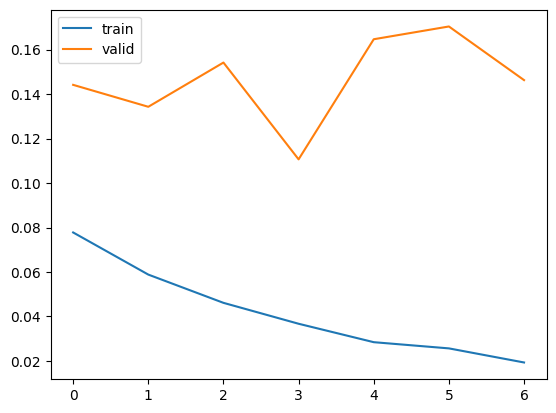

In [ ]:
plt.plot(train_losses[1:], label='train')
plt.plot(val_losses[1:], label='valid')
plt.legend()
plt.show()

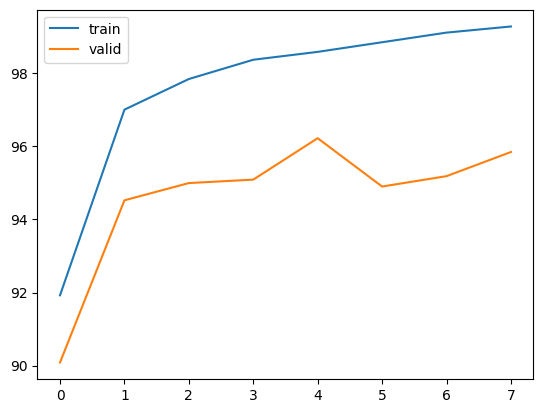

In [ ]:
plt.plot(train_metric_log["acc"], label='train')
plt.plot(val_metric_log["acc"], label='valid')
plt.legend()
plt.show()

## 3.3 Testing

In [ ]:
net.eval()
test_correct = 0.0
test_total = 0.0
y_true, y_pred, y_logit = [], [], []

for batch_idx, (x, y) in tqdm(enumerate(data_loader['test']), total=len(data_loader['test'])):
    y = y.unsqueeze(1).float()  # prepare targets
    x, y = x.to(device), y.to(device)
    logit = net(x)
    pred = (torch.sigmoid(logit) >= 0.5)

    test_correct += (pred == y).sum().item()
    test_total += x.size(0)

    y_logit += logit.cpu().tolist()
    y_pred += pred.cpu().tolist()
    y_true += y.cpu().tolist()

print(test_correct/test_total * 100.)
print(roc_auc_score(y_true, y_logit, average='micro'))
print(average_precision_score(y_true, y_logit, average='micro'))

  0%|          | 0/20 [00:00<?, ?it/s]

92.78846153846155
0.9780955511724742
0.9855004071260349


## 3.4 Other metrics for binary classificatoin

Let's plot a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

A confusion matrix is to evaluate the quality of the output of a classifier on the data set. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_true, y_pred)

array([[194,  40],
       [  5, 385]])

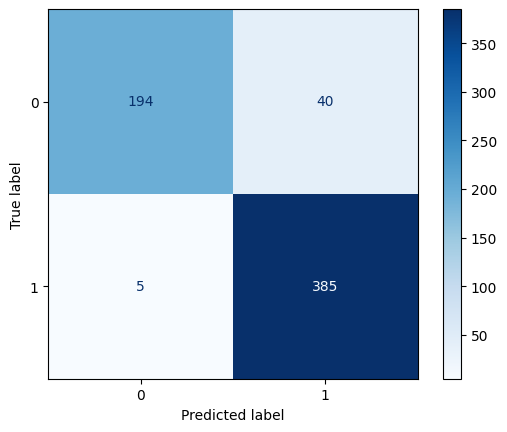

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=range(2),
    cmap='Blues'
)
plt.show()

From the confusion matrix, we can see each number of examples predicted correct or wrong by our model, for both classes seperately.  
We call the numbers from this confusion matrix `True Positives, True Negatives, False Positives, and False Negatives` respectively.

In the binary case, we can extract each value directly as follows:

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

## 3.5 Additional metrics for binary classificatoin (Optional)

Now, we can calculate some basic metrics from these values.

- Accuracy
- Positive Predictive Value (Precision)
- True Positive Rate (Recall, Sensitivity)
- True Negative Rate (Specificity)
- False Positive Rate (Type I error)
- False Negative Rate (Type II error)
- F1 score (Harmonic mean of precision and recall)
- AUROC
- AUPRC

In [ ]:
result = {}

result['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
result['precision'] = tp / (tp + fp)
result['recall'] = tp / (tp + fn)
result['specificity'] = tn / (tp + fn)
result['false_positive_rate'] = fp / (fp + tn)
result['false_negative_rate'] = fn / (tp + fn)

In [ ]:
# sklearn provides functions for widely used metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("accuracy :", accuracy_score(y_true, y_pred))
print("precision :", precision_score(y_true, y_pred))
print("recall :", recall_score(y_true, y_pred))
print("f1 :", f1_score(y_true, y_pred))

accuracy : 0.9278846153846154
precision : 0.9058823529411765
recall : 0.9871794871794872
f1 : 0.9447852760736197


In [ ]:
# AUROC, AUPRC
from sklearn.metrics import roc_auc_score, average_precision_score
result["auroc"] = roc_auc_score(y_true, y_logit, average='micro')
result["auprc"] = average_precision_score(y_true, y_logit, average='micro')

In [ ]:
def show_auroc_plot(y_test, y_pred_proba):

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test,  y_pred_proba)
    auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

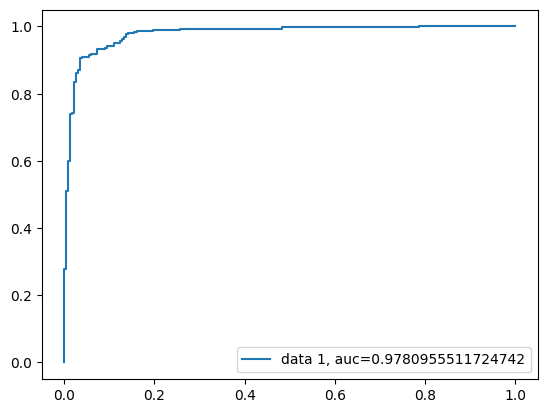

In [ ]:
show_auroc_plot(y_test=y_true, y_pred_proba=y_logit)

In [ ]:
for k,v in result.items():
    print(f"{k}  :  {v}")

accuracy  :  0.9278846153846154
precision  :  0.9058823529411765
recall  :  0.9871794871794872
specificity  :  0.49743589743589745
false_positive_rate  :  0.17094017094017094
false_negative_rate  :  0.01282051282051282
auroc  :  0.9780955511724742
auprc  :  0.9855004071260349
